In [12]:
# TODO : Remove that (just comes from a jax_md error where gpu isn't detected anymore)
import os
os.environ["JAX_PLATFORMS"] = "cpu"

import logging as lg
from enum import Enum
from functools import partial
from typing import Tuple

import jax
import numpy as np
import jax.numpy as jnp

from jax import vmap, jit
from jax import random, ops, lax

from flax import struct
from jax_md.rigid_body import RigidBody
from jax_md import simulate 
from jax_md import space, rigid_body, partition, quantity

from vivarium.experimental.environments.utils import normal
from vivarium.experimental.environments.base_env import BaseState, BaseEnv
from vivarium.experimental.environments.physics_engine import total_collision_energy, friction_force, dynamics_fn

### Define the constants and the classes of the environment to store its state ###

SPACE_NDIMS = 2

# TODO : Should maybe just let the user define its own class and just have a base class State with time ... 
class EntityType(Enum):
    AGENT = 0
    OBJECT = 1

class EntitySensedType(Enum):
    PREY = 0
    PRED = 1
    RESSOURCE = 2
    POISON = 3

@struct.dataclass
class EntityState(simulate.NVEState):
    entity_type: jnp.array
    entity_idx: jnp.array
    diameter: jnp.array
    friction: jnp.array
    exists: jnp.array
    ent_sensed_type: jnp.array

@struct.dataclass
class ParticleState:
    ent_idx: jnp.array
    color: jnp.array
    
@struct.dataclass
class AgentState(ParticleState):
    prox: jnp.array
    motor: jnp.array
    proximity_map_dist: jnp.array
    proximity_map_theta: jnp.array
    behavior: jnp.array
    params: jnp.array
    sensed: jnp.array
    wheel_diameter: jnp.array
    speed_mul: jnp.array
    max_speed: jnp.array
    theta_mul: jnp.array    
    proxs_dist_max: jnp.array
    proxs_cos_min: jnp.array

@struct.dataclass
class ObjectState(ParticleState):
    pass

@struct.dataclass
class State(BaseState):
    time: jnp.int32
    box_size: jnp.int32
    max_agents: jnp.int32
    max_objects: jnp.int32
    neighbor_radius: jnp.float32
    dt: jnp.float32  # Give a more explicit name
    collision_alpha: jnp.float32
    collision_eps: jnp.float32
    entities: EntityState
    agents: AgentState
    objects: ObjectState    

### Define helper functions used to step from one state to the next one ###


#--- 2 Functions to compute the motor activations of braitenberg agents ---#

# TODO : See how we'll handle this on client side
class Behaviors(Enum):
    FEAR = 0
    AGGRESSION = 1
    LOVE = 2
    SHY = 3
    NOOP = 4
    MANUAL = 5

# TODO : Could find a better name than params ? Or can be good enough
behavior_params = {
    Behaviors.FEAR.value: jnp.array(
        [[1., 0., 0.], 
         [0., 1., 0.]]),
    Behaviors.AGGRESSION.value: jnp.array(
        [[0., 1., 0.], 
         [1., 0., 0.]]),
    Behaviors.LOVE.value: jnp.array(
        [[-1., 0., 1.], 
         [0., -1., 1.]]),
    Behaviors.SHY.value: jnp.array(
        [[0., -1., 1.], 
         [-1., 0., 1.]]),
    Behaviors.NOOP.value: jnp.array(
        [[0., 0., 0.], 
         [0., 0., 0.]]),
}

def behavior_to_params(behavior):
    return behavior_params[behavior]

def compute_motor(proxs, params):
    """Compute motor values according to proximeter values and "params"

    :param proxs: _description_
    :param params: _description_
    :return: _description_
    """
    return params.dot(jnp.hstack((proxs, 1.)))

sensorimotor = vmap(compute_motor, in_axes=(0, 0))

def lr_2_fwd_rot(left_spd, right_spd, base_length, wheel_diameter):
    fwd = (wheel_diameter / 4.) * (left_spd + right_spd)
    rot = 0.5 * (wheel_diameter / base_length) * (right_spd - left_spd)
    return fwd, rot

def fwd_rot_2_lr(fwd, rot, base_length, wheel_diameter):
    left = ((2.0 * fwd) - (rot * base_length)) / wheel_diameter
    right = ((2.0 * fwd) + (rot * base_length)) / wheel_diameter
    return left, right

def motor_command(wheel_activation, base_length, wheel_diameter):
    fwd, rot = lr_2_fwd_rot(wheel_activation[0], wheel_activation[1], base_length, wheel_diameter)
    return fwd, rot

motor_command = vmap(motor_command, (0, 0, 0))


#--- 3 Functions to compute the different forces in the environment ---#

# TODO : Refactor the code in order to simply the definition of a total force fn incorporating different forces
def braintenberg_force_fn(displacement):
    coll_force_fn = quantity.force(partial(total_collision_energy, displacement=displacement))

    def collision_force(state, neighbor, exists_mask):
        return coll_force_fn(
            state.entities.position.center,
            neighbor=neighbor,
            exists_mask=exists_mask,
            diameter=state.entities.diameter,
            epsilon=state.collision_eps,
            alpha=state.collision_alpha
            )

    def motor_force(state, exists_mask):
        agent_idx = state.agents.ent_idx

        body = rigid_body.RigidBody(
            center=state.entities.position.center[agent_idx],
            orientation=state.entities.position.orientation[agent_idx]
            )
        
        n = normal(body.orientation)

        fwd, rot = motor_command(
            state.agents.motor,
            state.entities.diameter[agent_idx],
            state.agents.wheel_diameter
            )
        # `a_max` arg is deprecated in recent versions of jax, replaced by `max`
        fwd = jnp.clip(fwd, a_max=state.agents.max_speed)

        cur_vel = state.entities.momentum.center[agent_idx] / state.entities.mass.center[agent_idx]
        cur_fwd_vel = vmap(jnp.dot)(cur_vel, n)
        cur_rot_vel = state.entities.momentum.orientation[agent_idx] / state.entities.mass.orientation[agent_idx]
        
        fwd_delta = fwd - cur_fwd_vel
        rot_delta = rot - cur_rot_vel

        fwd_force = n * jnp.tile(fwd_delta, (SPACE_NDIMS, 1)).T * jnp.tile(state.agents.speed_mul, (SPACE_NDIMS, 1)).T
        rot_force = rot_delta * state.agents.theta_mul

        center=jnp.zeros_like(state.entities.position.center).at[agent_idx].set(fwd_force)
        orientation=jnp.zeros_like(state.entities.position.orientation).at[agent_idx].set(rot_force)

        # apply mask to make non existing agents stand still
        orientation = jnp.where(exists_mask, orientation, 0.)
        # Because position has SPACE_NDMS dims, need to stack the mask to give it the same shape as center
        exists_mask = jnp.stack([exists_mask] * SPACE_NDIMS, axis=1)
        center = jnp.where(exists_mask, center, 0.)

        return rigid_body.RigidBody(center=center,
                                    orientation=orientation)
    
    def force_fn(state, neighbor, exists_mask):
        mf = motor_force(state, exists_mask)
        cf = collision_force(state, neighbor, exists_mask)
        ff = friction_force(state, exists_mask)
        
        center = cf + ff + mf.center
        orientation = mf.orientation
        return rigid_body.RigidBody(center=center, orientation=orientation)

    return force_fn


#--- 1 Functions to compute the proximeter of braitenberg agents ---#

def relative_position(displ, theta):
    """
    Compute the relative distance and angle from a source agent to a target agent
    :param displ: Displacement vector (jnp arrray with shape (2,) from source to target
    :param theta: Orientation of the source agent (in the reference frame of the map)
    :return: dist: distance from source to target.
    relative_theta: relative angle of the target in the reference frame of the source agent (front direction at angle 0)
    """
    dist = jnp.linalg.norm(displ)
    norm_displ = displ / dist
    theta_displ = jnp.arccos(norm_displ[0]) * jnp.sign(jnp.arcsin(norm_displ[1]))
    relative_theta = theta_displ - theta
    return dist, relative_theta

proximity_map = vmap(relative_position, (0, 0))

# TODO : Refactor the code bc pretty ugly to have 4 arguments returned here
def get_relative_displacement(state, agents_neighs_idx, displacement_fn):
    body = state.entities.position
    senders, receivers = agents_neighs_idx
    Ra = body.center[senders]
    Rb = body.center[receivers]
    dR = - space.map_bond(displacement_fn)(Ra, Rb)  # Looks like it should be opposite, but don't understand why

    dist, theta = proximity_map(dR, body.orientation[senders])
    proximity_map_dist = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_dist = proximity_map_dist.at[senders, receivers].set(dist)
    proximity_map_theta = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_theta = proximity_map_theta.at[senders, receivers].set(theta)
    return dist, theta, proximity_map_dist, proximity_map_theta

# TODO : Could potentially refactor these functions with vmaps to make them easier (not a priority)
def sensor_fn(dist, relative_theta, dist_max, cos_min, target_exists):
    """
    Compute the proximeter activations (left, right) induced by the presence of an entity
    :param dist: distance from the agent to the entity
    :param relative_theta: angle of the entity in the reference frame of the agent (front direction at angle 0)
    :param dist_max: Max distance of the proximiter (will return 0. above this distance)
    :param cos_min: Field of view as a cosinus (e.g. cos_min = 0 means a pi/4 FoV on each proximeter, so pi/2 in total)
    :return: left and right proximeter activation in a jnp array with shape (2,)
    """
    cos_dir = jnp.cos(relative_theta)
    prox = 1. - (dist / dist_max)
    in_view = jnp.logical_and(dist < dist_max, cos_dir > cos_min)
    at_left = jnp.logical_and(True, jnp.sin(relative_theta) >= 0)
    left = in_view * at_left * prox
    right = in_view * (1. - at_left) * prox
    return jnp.array([left, right]) * target_exists  # i.e. 0 if target does not exist

sensor_fn = vmap(sensor_fn, (0, 0, 0, 0, 0))

def sensor(dist, relative_theta, dist_max, cos_min, max_agents, senders, target_exists):
    raw_proxs = sensor_fn(dist, relative_theta, dist_max, cos_min, target_exists)

    # Computes the maximum within the proximeter activations of agents on all their neigbhors.
    proxs = ops.segment_max(
        raw_proxs,
        senders, 
        max_agents)
    
    return proxs

# TODO : Could potentially refactor this part of the code with a function using vmap (not a priority)
def compute_prox(state, agents_neighs_idx, target_exists_mask, displacement):
    """
    Set agents' proximeter activations
    :param state: full simulation State
    :param agents_neighs_idx: Neighbor representation, where sources are only agents. Matrix of shape (2, n_pairs),
    where n_pairs is the number of neighbor entity pairs where sources (first row) are agent indexes.
    :param target_exists_mask: Specify which target entities exist. Vector with shape (n_entities,).
    target_exists_mask[i] is True (resp. False) if entity of index i in state.entities exists (resp. don't exist).
    :return:
    """
    body = state.entities.position
    senders, receivers = agents_neighs_idx
    Ra = body.center[senders]
    Rb = body.center[receivers]
    dR = - space.map_bond(displacement)(Ra, Rb)  # Looks like it should be opposite, but don't understand why

    # Create distance and angle maps between entities
    dist, theta = proximity_map(dR, body.orientation[senders])
    proximity_map_dist = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_dist = proximity_map_dist.at[senders, receivers].set(dist)
    proximity_map_theta = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_theta = proximity_map_theta.at[senders, receivers].set(theta)

    # TODO : Could refactor this function bc there's a lot of redundancies in the arguments (state.agents)
    mask = target_exists_mask[agents_neighs_idx[1, :]]   
    prox = sensor(dist, theta, state.agents.proxs_dist_max[senders],
                    state.agents.proxs_cos_min[senders], len(state.agents.ent_idx), senders, mask)
    
    # TODO Could refactor this to have a cleaner split of functions (instead of returning 3 args here) 
    return prox, proximity_map_dist, proximity_map_theta

### New functions for selective sensors ####

def mask_sensors(state, agent_raw_proxs, ent_type_id, ent_target_idx):
    ### Put ent_sensed_type instead of entity_type ###
    mask = jnp.where(state.entities.ent_sensed_type[ent_target_idx] == ent_type_id, 0, 1)
    mask = jnp.expand_dims(mask, 1)
    mask = jnp.broadcast_to(mask, agent_raw_proxs.shape)
    return agent_raw_proxs * mask

def dont_change(state, agent_raw_proxs, ent_type_id, ent_target_idx):
    return agent_raw_proxs

# TODO : Use a fori_loop on this later
def compute_behavior_prox(state, agent_raw_proxs, ent_target_idx, sensed_entities):
    for ent_type_id, sensed in enumerate(sensed_entities):
        agent_raw_proxs = jax.lax.cond(sensed, dont_change, mask_sensors, state, agent_raw_proxs, ent_type_id, ent_target_idx)
    proxs = jnp.max(agent_raw_proxs, axis=0)

    return proxs

### TODO 1 :  
def compute_behavior_proxs_motors(state, params, sensed, agent_raw_proxs, ent_target_idx):
    behavior_prox = compute_behavior_prox(state, agent_raw_proxs, ent_target_idx, sensed)
    behavior_motors = compute_motor(behavior_prox, params)
    return behavior_prox, behavior_motors

compute_all_behavior_proxs_motors = vmap(compute_behavior_proxs_motors, in_axes=(None, 0, 0, None, None))

def compute_agent_proxs_motors(state, agent_idx, params, sensed, raw_proxs, ag_idx_dense_senders, ag_idx_dense_receivers):
    ent_ag_idx = ag_idx_dense_senders[agent_idx]
    ent_target_idx = ag_idx_dense_receivers[agent_idx]
    agent_raw_proxs = raw_proxs[ent_ag_idx]

    agent_proxs, agent_motors = compute_all_behavior_proxs_motors(state, params, sensed, agent_raw_proxs, ent_target_idx)
    mean_agent_motors = jnp.mean(agent_motors, axis=0)

    return agent_proxs, mean_agent_motors

compute_all_agents_proxs_motors = vmap(compute_agent_proxs_motors, in_axes=(None, 0, 0, 0, None, None, None))


In [13]:
class SelectiveSensorsBraitenbergEnv(BaseEnv):
    def __init__(
            self,
            box_size=100,
            dt=0.1,
            max_agents=10,
            max_objects=2,
            neighbor_radius=100.,
            collision_alpha=0.5,
            collision_eps=0.1,
            n_dims=2,
            seed=0,
            diameter=5.0,
            friction=0.1,
            mass_center=1.0,
            mass_orientation=0.125,
            existing_agents=10,
            existing_objects=2,
            behaviors=Behaviors.AGGRESSION.value,
            wheel_diameter=2.0,
            speed_mul=1.0,
            max_speed=10.0,
            theta_mul=1.0,
            prox_dist_max=40.0,
            prox_cos_min=0.0,
            agents_color=jnp.array([0.0, 0.0, 1.0]),
            objects_color=jnp.array([1.0, 0.0, 0.0])
    ):
        
        # TODO : add docstrings
        # general parameters
        self.box_size = box_size
        self.dt = dt
        self.max_agents = max_agents
        self.max_objects = max_objects
        self.neighbor_radius = neighbor_radius
        self.collision_alpha = collision_alpha
        self.collision_eps = collision_eps
        self.n_dims = n_dims
        self.seed = seed
        # entities parameters
        self.diameter = diameter
        self.friction = friction
        self.mass_center = mass_center
        self.mass_orientation = mass_orientation
        self.existing_agents = existing_agents
        self.existing_objects = existing_objects
        # agents parameters
        self.behaviors = behaviors
        self.wheel_diameter = wheel_diameter
        self.speed_mul = speed_mul
        self.max_speed = max_speed
        self.theta_mul = theta_mul
        self.prox_dist_max = prox_dist_max
        self.prox_cos_min = prox_cos_min
        self.agents_color = agents_color
        # objects parameters
        self.objects_color = objects_color
        # TODO : other parameters are defined when init_state is called, maybe coud / should set them to None here ? 
        # Or can also directly initialize the state ... and jax_md attributes in this function too ...

    def init_state(self) -> State:
        key = random.PRNGKey(self.seed)
        key, key_agents_pos, key_objects_pos, key_orientations = random.split(key, 4)

        entities = self.init_entities(key_agents_pos, key_objects_pos, key_orientations)
        agents = self.init_agents()
        objects = self.init_objects()
        state = self.init_complete_state(entities, agents, objects)

        # Create jax_md attributes for environment physics
        # TODO : Might not be optimal to just use this function here (harder to understand what's in the class attributes)
        state = self.init_env_physics(key, state)

        return state
        
    def distance(self, point1, point2):
            diff = self.displacement(point1, point2)
            squared_diff = jnp.sum(jnp.square(diff))
            return jnp.sqrt(squared_diff)
    
    # TODO See how to clean the function to remove the agents_neighs_idx
    @partial(jit, static_argnums=(0,))
    def _step(self, state: State, neighbors: jnp.array, agents_neighs_idx: jnp.array, ag_idx_dense: jnp.array) -> Tuple[State, jnp.array]:

        dist, relative_theta, proximity_dist_map, proximity_dist_theta = get_relative_displacement(state, agents_neighs_idx, displacement_fn=self.displacement)
        senders, receivers = agents_neighs_idx

        dist_max = state.agents.proxs_dist_max[senders]
        cos_min = state.agents.proxs_cos_min[senders]
        targer_exist_mask = state.entities.exists[agents_neighs_idx[1, :]]
        raw_proxs = sensor_fn(dist, relative_theta, dist_max, cos_min, targer_exist_mask)

        # TODO : Could even just pass ag_idx_dense in the fn and do this inside
        ag_idx_dense_senders, ag_idx_dense_receivers = ag_idx_dense

        agent_proxs, mean_agent_motors = compute_all_agents_proxs_motors(
            state,
            state.agents.ent_idx,
            state.agents.params,
            state.agents.sensed,
            raw_proxs,
            ag_idx_dense_senders,
            ag_idx_dense_receivers,
        )

        # TODO : Relou de rajouter les proximeters non ? En vrai non juste un array de proximeters pour chaque agent
        agents = state.agents.replace(
            prox=agent_proxs, 
            proximity_map_dist=proximity_dist_map, 
            proximity_map_theta=proximity_dist_theta,
            motor=mean_agent_motors
        )

        # Last block unchanged
        state = state.replace(agents=agents)
        entities = self.apply_physics(state, neighbors)
        state = state.replace(time=state.time+1, entities=entities)
        neighbors = neighbors.update(state.entities.position.center)
        return state, neighbors
    
    def step(self, state: State) -> State:
        current_state = state
        state, neighbors = self._step(current_state, self.neighbors, self.agents_neighs_idx, self.agents_idx_dense)

        if self.neighbors.did_buffer_overflow:
            # reallocate neighbors and run the simulation from current_state
            lg.warning(f'NEIGHBORS BUFFER OVERFLOW at step {state.time}: rebuilding neighbors')
            neighbors = self.allocate_neighbors(state)
            assert not neighbors.did_buffer_overflow

        self.neighbors = neighbors
        return state

    # TODO See how we deal with agents_neighs_idx
    def allocate_neighbors(self, state, position=None):
        position = state.entities.position.center if position is None else position
        neighbors = self.neighbor_fn.allocate(position)

        # Also update the neighbor idx of agents (not the cleanest to attribute it to with self here)
        ag_idx = state.entities.entity_type[neighbors.idx[0]] == EntityType.AGENT.value
        self.agents_neighs_idx = neighbors.idx[:, ag_idx]
        agents_idx_dense_senders = jnp.array([jnp.argwhere(jnp.equal(self.agents_neighs_idx[0, :], idx)).flatten() for idx in jnp.arange(self.max_agents)])
        # agents_idx_dense_receivers = jnp.array([jnp.argwhere(jnp.equal(self.agents_neighs_idx[1, :], idx)).flatten() for idx in jnp.arange(self.max_agents)])
        agents_idx_dense_receivers = self.agents_neighs_idx[1, :][agents_idx_dense_senders]
        # self.agents_idx_dense = jnp.array([jnp.where(self.agents_neighs_idx[0, :] == idx).flatten() for idx in range(self.max_agents)])
        self.agents_idx_dense = agents_idx_dense_senders, agents_idx_dense_receivers
        return neighbors
    
    # TODO : Modify these functions so can give either 1 param and apply it to every entity or give custom ones
    def init_entities(self, key_agents_pos, key_objects_pos, key_orientations):
        n_entities = self.max_agents + self.max_objects # we store the entities data in jax arrays of length max_agents + max_objects 
        # Assign random positions to each entity in the environment
        agents_positions = random.uniform(key_agents_pos, (self.max_agents, self.n_dims)) * self.box_size
        objects_positions = random.uniform(key_objects_pos, (self.max_objects, self.n_dims)) * self.box_size
        positions = jnp.concatenate((agents_positions, objects_positions))
        # Assign random orientations between 0 and 2*pi to each entity
        orientations = random.uniform(key_orientations, (n_entities,)) * 2 * jnp.pi
        # Assign types to the entities
        agents_entities = jnp.full(self.max_agents, EntityType.AGENT.value)
        object_entities = jnp.full(self.max_objects, EntityType.OBJECT.value)
        entity_types = jnp.concatenate((agents_entities, object_entities), dtype=int)
        # Define arrays with existing entities
        exists_agents = jnp.concatenate((jnp.ones((self.existing_agents)), jnp.zeros((self.max_agents - self.existing_agents))))
        exists_objects = jnp.concatenate((jnp.ones((self.existing_objects)), jnp.zeros((self.max_objects - self.existing_objects))))
        exists = jnp.concatenate((exists_agents, exists_objects), dtype=int)

        ### TODO : Actually find a way to init this later
        ent_sensed_types = jnp.zeros(n_entities)

        return EntityState(
            position=RigidBody(center=positions, orientation=orientations),
            momentum=None,
            force=RigidBody(center=jnp.zeros((n_entities, 2)), orientation=jnp.zeros(n_entities)),
            mass=RigidBody(center=jnp.full((n_entities, 1), self.mass_center), orientation=jnp.full((n_entities), self.mass_orientation)),
            entity_type=entity_types,
            ent_sensed_type=ent_sensed_types,
            entity_idx = jnp.array(list(range(self.max_agents)) + list(range(self.max_objects))),
            diameter=jnp.full((n_entities), self.diameter),
            friction=jnp.full((n_entities), self.friction),
            exists=exists
        )
    
    def init_agents(self):
        # TODO : Change that so can define custom behaviors (e.g w a list)
        # Use numpy cuz jnp elements cannot be keys of a dict
        behaviors = np.full((self.max_agents), self.behaviors)
        # Cannot use a vmap fn because of dictionary, cannot have jax elements as a key because its unhashable
        params = jnp.array([behavior_to_params(behavior) for behavior in behaviors])

        ### TODO : Change that later
        sensed = jnp.zeros(self.max_agents)

        return AgentState(
            # idx in the entities (ent_idx) state to map agents information in the different data structures
            ent_idx=jnp.arange(self.max_agents, dtype=int), 
            prox=jnp.zeros((self.max_agents, 2)),
            motor=jnp.zeros((self.max_agents, 2)),
            behavior=behaviors,
            params=params,
            sensed=sensed,
            wheel_diameter=jnp.full((self.max_agents), self.wheel_diameter),
            speed_mul=jnp.full((self.max_agents), self.speed_mul),
            max_speed=jnp.full((self.max_agents), self.max_speed),
            theta_mul=jnp.full((self.max_agents), self.theta_mul),
            proxs_dist_max=jnp.full((self.max_agents), self.prox_dist_max),
            proxs_cos_min=jnp.full((self.max_agents), self.prox_cos_min),
            proximity_map_dist=jnp.zeros((self.max_agents, 1)),
            proximity_map_theta=jnp.zeros((self.max_agents, 1)),
            color=jnp.tile(self.agents_color, (self.max_agents, 1))
        )

    def init_objects(self):
        # Entities idx of objects
        start_idx, stop_idx = self.max_agents, self.max_agents + self.max_objects 
        objects_ent_idx = jnp.arange(start_idx, stop_idx, dtype=int)

        return ObjectState(
            ent_idx=objects_ent_idx,
            color=jnp.tile(self.objects_color, (self.max_objects, 1))
        )
    
    def init_complete_state(self, entities, agents, objects):
        lg.info('Initializing state')
        return State(
            time=0,
            box_size=self.box_size,
            max_agents=self.max_agents,
            max_objects=self.max_objects,
            neighbor_radius=self.neighbor_radius,
            collision_alpha=self.collision_alpha,
            collision_eps=self.collision_eps,
            dt=self.dt,
            entities=entities,
            agents=agents,
            objects=objects
        )   
    
    def init_env_physics(self, key, state):
        lg.info("Initializing environment's physics features")
        key, physics_key = random.split(key)
        self.displacement, self.shift = space.periodic(self.box_size)
        self.init_fn, self.apply_physics = dynamics_fn(self.displacement, self.shift, braintenberg_force_fn)
        self.neighbor_fn = partition.neighbor_list(
            self.displacement, 
            self.box_size,
            r_cutoff=self.neighbor_radius,
            dr_threshold=10.,
            capacity_multiplier=1.5,
            format=partition.Sparse
        )

        state = self.init_fn(state, physics_key)
        lg.info("Allocating neighbors")
        neighbors = self.allocate_neighbors(state)
        self.neighbors = neighbors

        return state


In [14]:
env = SelectiveSensorsBraitenbergEnv(
    max_agents=10,
    max_objects=10,
    existing_agents=10,
    existing_objects=10
)

state = env.init_state()

In [15]:
n_preys = 5
n_preds = 5
n_ress = 5
n_pois = 5

Lets define an env with 5 preys, 5 predators, 5 ressources and 5 agents

In [16]:
print(f"prey: {EntitySensedType.PREY.value}")
print(f"pred: {EntitySensedType.PRED.value}")
print(f"ressource: {EntitySensedType.RESSOURCE.value}")
print(f"poison: {EntitySensedType.POISON.value}")

prey: 0
pred: 1
ressource: 2
poison: 3


In [17]:
sensed_ent_types = jnp.concatenate([
    jnp.full(n_preys, EntitySensedType.PREY.value),
    jnp.full(n_preds, EntitySensedType.PRED.value),
    jnp.full(n_ress, EntitySensedType.RESSOURCE.value),
    jnp.full(n_pois, EntitySensedType.POISON.value),
])

In [18]:
entities = state.entities.replace(ent_sensed_type=sensed_ent_types)
entities.ent_sensed_type

Array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],      dtype=int32, weak_type=True)

Now lets give to prey agents a behavior of love towards ressources and preys, and fear towards predators and poison.
Let's also give a behavior of aggression to predators towards preys, and a behavior of fear towards poison. 

In [19]:
# Prey behaviors
love = behavior_to_params(Behaviors.LOVE.value)
fear = behavior_to_params(Behaviors.FEAR.value)
sensed_love = jnp.array([1, 0, 1, 0])
sensed_fear = jnp.array([0, 1, 0, 1])
prey_params = jnp.array([love, fear])
prey_sensed = jnp.array([sensed_love, sensed_fear])

# Do like if we had batches of params and sensed entities for all agents
prey_batch_params = jnp.tile(prey_params[None], (n_preys, 1, 1 ,1))
prey_batch_sensed = jnp.tile(prey_sensed[None], (n_preys, 1, 1))
print(prey_batch_params.shape, prey_batch_sensed.shape)

(5, 2, 2, 3) (5, 2, 4)


In [20]:
# Pred behaviors
aggr = behavior_to_params(Behaviors.AGGRESSION.value)
fear = behavior_to_params(Behaviors.FEAR.value)
sensed_aggr = jnp.array([1, 0, 0, 0])
sensed_fear = jnp.array([0, 0, 0, 1])
pred_params = jnp.array([aggr, fear])
pred_sensed = jnp.array([sensed_aggr, sensed_fear])

# Do like if we had batches of params and sensed entities for all agents
pred_batch_params = jnp.tile(pred_params[None], (n_preys, 1, 1 ,1))
pred_batch_sensed = jnp.tile(pred_sensed[None], (n_preys, 1, 1))
print(pred_batch_params.shape, pred_batch_sensed.shape)

(5, 2, 2, 3) (5, 2, 4)


In [21]:
params = jnp.concatenate([prey_batch_params, pred_batch_params], axis=0)
sensed = jnp.concatenate([prey_batch_sensed, pred_batch_sensed], axis=0)
print(params.shape, sensed.shape)

(10, 2, 2, 3) (10, 2, 4)


Finally lets give some colors to all entities: Blue for preys, red for preds, green for ressources and purple for poison

In [22]:
prey_color = jnp.array([0., 0., 1.])
pred_color = jnp.array([1., 0., 0.])

prey_color=jnp.tile(prey_color, (n_preys, 1))
pred_color=jnp.tile(pred_color, (n_preds, 1))

agent_colors = jnp.concatenate([
    prey_color,
    pred_color
])

In [23]:
agents = state.agents.replace(
    params=params,
    sensed=sensed,
    color=agent_colors
)

In [24]:
res_color = jnp.array([0., 1., 0.])
pois_color = jnp.array([1., 0., 1.])

res_color=jnp.tile(res_color, (n_preys, 1))
pois_color=jnp.tile(pois_color, (n_preds, 1))

objects_colors = jnp.concatenate([
    res_color,
    pois_color
])

objects = state.objects.replace(color=objects_colors)

In [25]:
state = state.replace(
    entities=entities,
    agents=agents,
    objects=objects)

In [27]:
from vivarium.experimental.environments.braitenberg.render import render, render_history

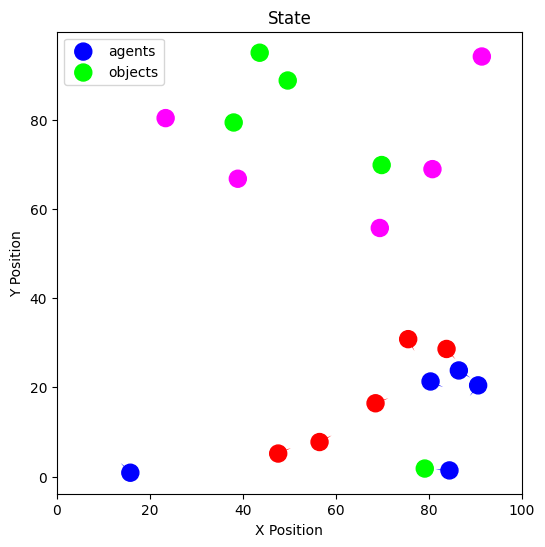

In [29]:
render(state)

In [30]:
n_steps = 10000
hist = []

for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

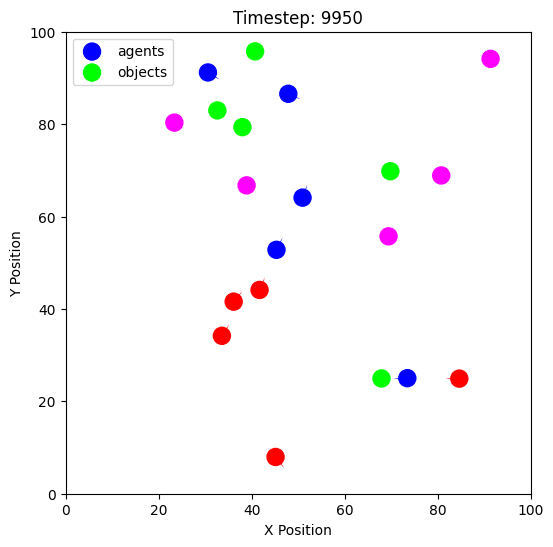

In [31]:
render_history(hist, skip_frames=50)